In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import scipy.stats as ss

plt.style.use('ggplot')

Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

### Описание колонок
* value – значения метрики
* experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

**Задача**

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

Первая загрузка файла показала, что необходимо добавить дополнительные параметры разделителей в датасете и колонки с индексами.

In [2]:
revenue = pd.read_csv('hw_bootstrap.csv', sep=';', index_col=0)

In [3]:
revenue.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


Значения записаны не в подходщем формате, поэтому внесем изменения.

In [4]:
revenue['value'] = revenue.value.str.replace(',', '.').astype('float')

In [5]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


У нас всего 1000 наблюдений, пропущенных значений нет.

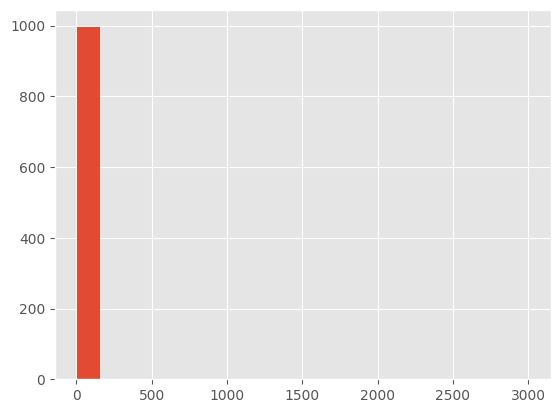

In [6]:
revenue.value.hist(bins=20);

Визуализация распределения говорит нам о том, что присутствуют серьезные выбросы. Можно было бы подумать о логарифмировании значений, но выбросы настолько велики, что это вряд ли поможет. Убедимся в этом, построив гистограмму логарифмированных значений.

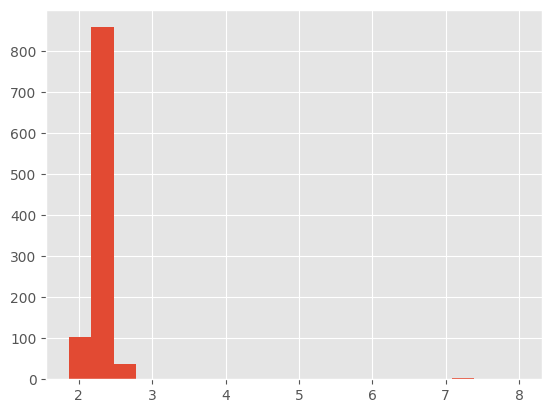

In [7]:
np.log(revenue.value).hist(bins=20);

In [8]:
revenue.describe()

,value
count,1000.000000
mean,18.674183
std,132.135045
min,6.436541
25%,9.414051
50%,10.020862
75%,10.669292
max,3000.000000


Запишем тест и контроль в отдельные переменные.

In [9]:
test = revenue.query('experimentVariant == "Treatment"')['value']

In [10]:
control = revenue.query('experimentVariant == "Control"')['value']

Проверим, есть ли разница в количестве наблюдений в тесте и контроле.

In [11]:
np.abs(control.count() - test.count())

0

У нас по 500 наблюдений в тесте и контроле.

Наличие таких серьезных выбросов уже говорит о том, что нельзя применять t-test, но всё же проведем еще тест на однородность дисперсий, используем критерий Левена.

In [12]:
ss.levene(test, control)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

P-value меньше 0.05, следовательно на 5%-ом уровне значимости можем отвергнуть нулевую гипотезу о равенстве дисперсий.

Посмотрим теперь на распределение значений в тесте и контроле по отдельности.

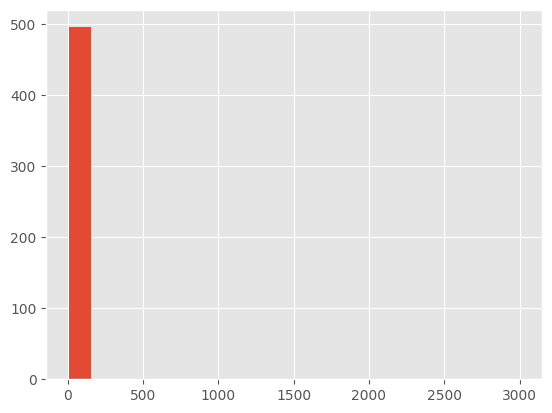

In [13]:
test.hist(bins=20);

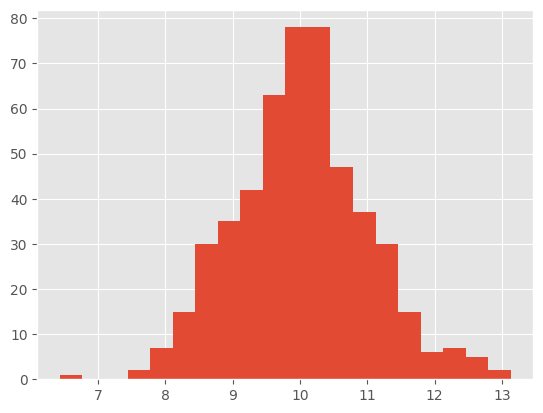

In [14]:
control.hist(bins=20);

Распределение в контроле близко к нормальному, а вот в тесте как раз обнаружились серьезные выбросы. Мы не знаем имела ли место какая-либо ошибка, поэтому не можем отбросить эти значения, и будем работать с тем, что есть.

Для проведения t-теста необходимо, чтобы распределение средних было нормальным, дисперсии были примерно одинаковы, а также чтобы не было серьезных выбросов. Следовательно проводить данный тест в нашем случае нельзя, но сделаем это, как того требует задание.

In [15]:
ss.ttest_ind(test, control)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

Результаты теста фиксируют наличие статистически значимого различия между средними в тесте и контроле (p-value меньше 0.05), но мы знаем про выбросы, поэтому верить не будем)

Также можно отметить, что если бы мы выбрали 1%-й уровень значимости, то результаты теста уже не позволили бы нам отвергнуть нулевую гипотезу. Такие неуверенные результаты также подтверждают необходиомсть поиска более подходящего инструмента для сравнения средних.

Проведем тест Манна-Уитни, нулевая гипотеза которого состоит в том, что между рангами выборок нет различий. Данный тест более устойчив к выбросам.

In [16]:
ss.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

Результаты теста не позволяют отвергнуть нулевую гипотезу (очень большое значение p-value), средовательно различий нет. Но результаты также не позволяют нам судить о разнице между средними в тесте и контроле, так как данный тест для этого не предназначен.

Далее объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа, который не имеет осообых требований к выборкам помимо их репрезентативности.

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Для начала проведем с помощью бутстрапа тест для средних. Ожидаем, что он покажет себя не с лучшей стороны из-за выбросов.

  0%|          | 0/1000 [00:00<?, ?it/s]

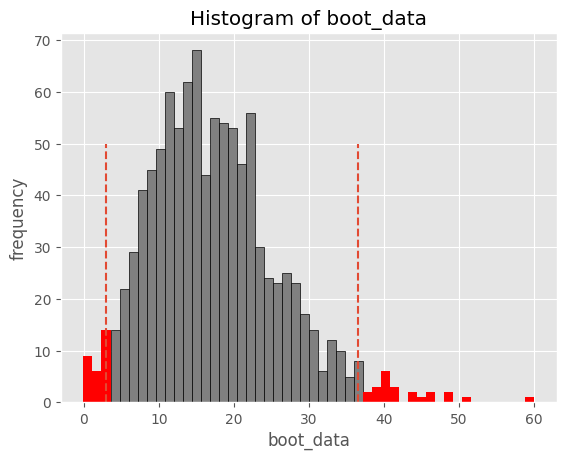

In [18]:
np.random.seed(8)

booted_data = get_bootstrap(test, control)

In [19]:
booted_data['p_value']

0.04349375175099932

Наши предположения подтвердились - гипотеза о равенстве средних на 5%-ом уровне значимости отвергается, но на 1%-ом уровне не может быть отвергнута. Мы опять получили достаточно ненадежные результаты, как и в случае t-теста.

Теперь перейдем к бутстрапу медиан, решение об использовании которого нужно было сделать после предварительного анализа данных. Использование медиан позволит нивелировать влияние выброса в наших данных.

  0%|          | 0/1000 [00:00<?, ?it/s]

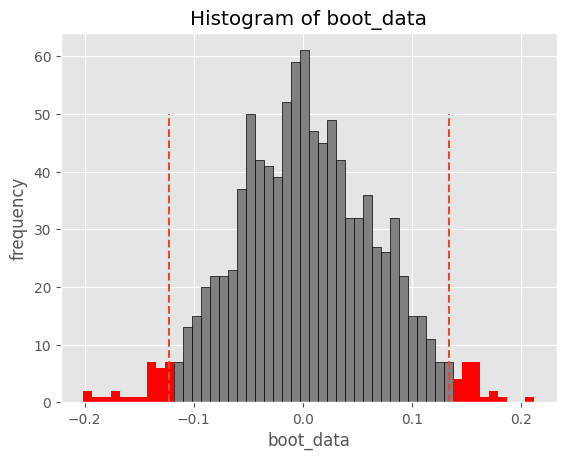

In [20]:
np.random.seed(8)

booted_data_median = get_bootstrap(test, control, statistic = np.median)

In [21]:
booted_data_median['p_value']

0.9592073673243208

In [22]:
booted_data_median['quants']

,0
0.025,-0.122464
0.975,0.133747


Теперь мы с уверенностью можем утверждать, что статистически значимого различия между средними (медианами) теста и контроля обнаружено не было, так как p-value сильно превосходит 0.05, а доверительный интервал для разниц медиан включает ноль.

### Итого
* В данных был обнаружен выброс, от которого мы не можем избавиться, не зная точно о причинах его появления.
* T-тест нам не подходит, а тест Манна-Уитни хоть и может быть использован в случае выбросов, не позволяет нам с уверенностью судить о наличии или отсутствии различий между средними.
* Наиболее подходящим представляется использованеи бутстрапа медиан.
* По результатам бутстрапа мы не отвергаем гипотезу о равенстве медиан в тесте и контроле, значимых различий нет. Выкатывать изменения на всех нет смысла.